In [14]:
import sqlite3
import pandas as pd
import altair as alt
import numpy as np
from scipy import stats

In [2]:
def read_data(file_name, day):
    con = sqlite3.connect(file_name)
    df = pd.read_sql("SELECT * FROM candles where day = '{}' order by dt".format(day), con)
    con.close()
    df['date'] = pd.to_datetime(df.dt)
    df['index'] = df.date
    df = df.set_index('index')
    return df

In [3]:
from altair import datum

def candle_chart(dataframe, index=None, past_ticks=120, future_ticks=60, index_range=None, reds=[], blues=[]):
    df = dataframe
    start_iloc = None
    end_iloc = None
    if index:
        i = df.index.get_loc(index)
        if i >= 0:
            start_iloc = max(0, i - past_ticks)
            end_iloc = min(len(df)-1, i + future_ticks)
            df = df.iloc[start_iloc:end_iloc]
    elif index_range:
        df = df.loc[index_range[0]:index_range[1]]
    
    tooltip_info = [alt.Tooltip('date:T', format='%m/%d %H:%M'), 'open', 'high', 'low', 'close', 'volume']
    
    open_close_color = alt.condition("datum.open < datum.close",
                                     alt.value("#ce375f"),
                                     alt.value("#3f2fb7"))

    rule = alt.Chart(df).mark_rule().encode(
        alt.X(
            'yearmonthdatehoursminutes(date):T',
            axis=alt.Axis(format='%m/%d %H:%M', title='date')
        ),
        alt.Y(
            'low',
            scale=alt.Scale(zero=False),
            axis=alt.Axis(title='Price')
        ),
        alt.Y2('high'),
        color=open_close_color,
        tooltip=tooltip_info
    )

    bar = alt.Chart(df).mark_bar().encode(
        x='yearmonthdatehoursminutes(date):T',
        y='open',
        y2='close',
        color=open_close_color,
        tooltip=tooltip_info
    )
    
    start = alt.Chart(df).mark_circle(size=10).encode(
        x='yearmonthdatehoursminutes(date):T',
        y='open',
        tooltip=tooltip_info
    )
    
    marking_rule = alt.Chart(df).mark_rule(color='gray').encode(
        alt.X(
            'yearmonthdatehoursminutes(date):T',
            axis=alt.Axis(format='%m/%d %H:%M', title='date')
        )        
    ).transform_filter(
        datum.dt == index
    )
    
    marking_reds = alt.Chart(df).mark_rule(color='#f59aa3').encode(        
        alt.X(
            'yearmonthdatehoursminutes(date):T',
            axis=alt.Axis(format='%m/%d %H:%M', title='date')
        )
    ).transform_filter(
        alt.FieldOneOfPredicate(field='dt', oneOf=reds)
    )
    
    marking_blues = alt.Chart(df).mark_rule(color='#34a7b2').encode(        
        alt.X(
            'yearmonthdatehoursminutes(date):T',
            axis=alt.Axis(format='%m/%d %H:%M', title='date')
        )
    ).transform_filter(
        alt.FieldOneOfPredicate(field='dt', oneOf=blues)
    )
    
    layer = alt.layer(marking_rule, marking_reds, marking_blues, rule, bar, start).properties(width=1200)

    vol = alt.Chart(df).mark_bar().encode(
        alt.X(
            'yearmonthdatehoursminutes(date):T',
            axis=alt.Axis(format='%m/%d %H:%M', title='')
        ),
        alt.Y(
            'volume',
            scale=alt.Scale(zero=False),
            axis=alt.Axis(title='Volume')
        )    
    )    
    layer2 = alt.layer(marking_rule, vol).properties(width=1200, height=50)

    return alt.vconcat(layer, layer2).properties(background='white')

In [11]:
def max_index(s):
    return np.flip(s).values.argmax()

def min_index(s):
    return np.flip(s).values.argmin()

def last(s):
    return s.values[0]

def linear_slope(s):
    y = s.values
    x = range(len(y))
    slope, intercept, r, p, std = stats.linregress(x,y)
    return slope

In [12]:
def calculate_candle(df):
    enter_price_type = 'close'

    df['max_index'] = df[::-1][enter_price_type].rolling(60, min_periods=1).apply(max_index, raw=False)
    df['max'] =df[::-1][enter_price_type].rolling(60, min_periods=1).max()
    df['min_index'] = df[::-1][enter_price_type].rolling(60, min_periods=1).apply(min_index, raw=False)
    df['min'] = df[::-1][enter_price_type].rolling(60, min_periods=1).min()
    df['last'] = df[::-1][enter_price_type].rolling(60, min_periods=1).apply(last, raw=False)

    df['call'] = df['max'] - df[enter_price_type]
    df['pull'] = df[enter_price_type] - df['min']

    df['call_max_index'] = df[::-1]['call'].rolling(60, min_periods=1).apply(max_index, raw=False)
    df['call_max'] =df[::-1]['call'].rolling(60, min_periods=1).max()

    df['pull_max_index'] = df[::-1]['pull'].rolling(60, min_periods=1).apply(max_index, raw=False)
    df['pull_max'] =df[::-1]['pull'].rolling(60, min_periods=1).max()
    
    ma_periods = (60, 120, 240, 480)
    for period in ma_periods:
        df['ma{}'.format(period)] = df['close'].rolling(period).mean()
        
    df['slope'] = df['close'].rolling(60).apply(linear_slope, raw=False)

In [105]:
reds = list(df[(df.call_max_index == 0) & (df.call_max > 0.3)].index.values)
blues = list(df[(df.pull_max_index == 0) & (df.pull_max > 0.3)].index.values)

In [6]:
df = read_data('CL000_1M.db', '20181210')
df.head()

,dt,open,high,low,close,volume,day,date
index,,,,,,,,
2018-12-10 08:00:00,20181210080000,52.03,52.34,52.03,52.21,758,20181210,2018-12-10 08:00:00
2018-12-10 08:01:00,20181210080100,52.21,52.22,52.16,52.20,370,20181210,2018-12-10 08:01:00
2018-12-10 08:02:00,20181210080200,52.20,52.38,52.19,52.38,355,20181210,2018-12-10 08:02:00
2018-12-10 08:03:00,20181210080300,52.38,52.58,52.38,52.51,628,20181210,2018-12-10 08:03:00
2018-12-10 08:04:00,20181210080400,52.50,52.56,52.50,52.51,215,20181210,2018-12-10 08:04:00


In [15]:
calculate_candle(df)

In [16]:
df

,dt,open,high,low,close,volume,day,date,max_index,max,...,pull,call_max_index,call_max,pull_max_index,pull_max,ma60,ma120,ma240,ma480,slope
index,,,,,,,,,,,,,,,,,,,,,
2018-12-10 08:00:00,20181210080000,52.03,52.34,52.03,52.21,758,20181210,2018-12-10 08:00:00,24.0,52.56,...,0.01,1.0,0.36,34.0,0.29,NaN,NaN,NaN,NaN,NaN
2018-12-10 08:01:00,20181210080100,52.21,52.22,52.16,52.20,370,20181210,2018-12-10 08:01:00,23.0,52.56,...,0.00,0.0,0.36,33.0,0.29,NaN,NaN,NaN,NaN,NaN
2018-12-10 08:02:00,20181210080200,52.20,52.38,52.19,52.38,355,20181210,2018-12-10 08:02:00,22.0,52.56,...,0.11,12.0,0.29,32.0,0.29,NaN,NaN,NaN,NaN,NaN
2018-12-10 08:03:00,20181210080300,52.38,52.58,52.38,52.51,628,20181210,2018-12-10 08:03:00,21.0,52.56,...,0.24,11.0,0.29,31.0,0.29,NaN,NaN,NaN,NaN,NaN
2018-12-10 08:04:00,20181210080400,52.50,52.56,52.50,52.51,215,20181210,2018-12-10 08:04:00,20.0,52.56,...,0.24,10.0,0.29,30.0,0.29,NaN,NaN,NaN,NaN,NaN
2018-12-10 08:05:00,20181210080500,52.51,52.53,52.41,52.47,238,20181210,2018-12-10 08:05:00,19.0,52.56,...,0.20,9.0,0.29,29.0,0.29,NaN,NaN,NaN,NaN,NaN
2018-12-10 08:06:00,20181210080600,52.46,52.47,52.37,52.41,121,20181210,2018-12-10 08:06:00,18.0,52.56,...,0.14,8.0,0.29,28.0,0.29,NaN,NaN,NaN,NaN,NaN
2018-12-10 08:07:00,20181210080700,52.41,52.43,52.40,52.43,150,20181210,2018-12-10 08:07:00,17.0,52.56,...,0.16,7.0,0.29,27.0,0.29,NaN,NaN,NaN,NaN,NaN
2018-12-10 08:08:00,20181210080800,52.42,52.42,52.40,52.41,28,20181210,2018-12-10 08:08:00,16.0,52.56,...,0.14,6.0,0.29,26.0,0.29,NaN,NaN,NaN,NaN,NaN


In [22]:
from scipy import stats
y =[1, 2, 3, 4]
x= range(len(y))

slope, intercept, r, p, std = stats.linregress(x,y)
print(slope, intercept, r, p, std)

1.0 1.0 1.0 1e-20 0.0


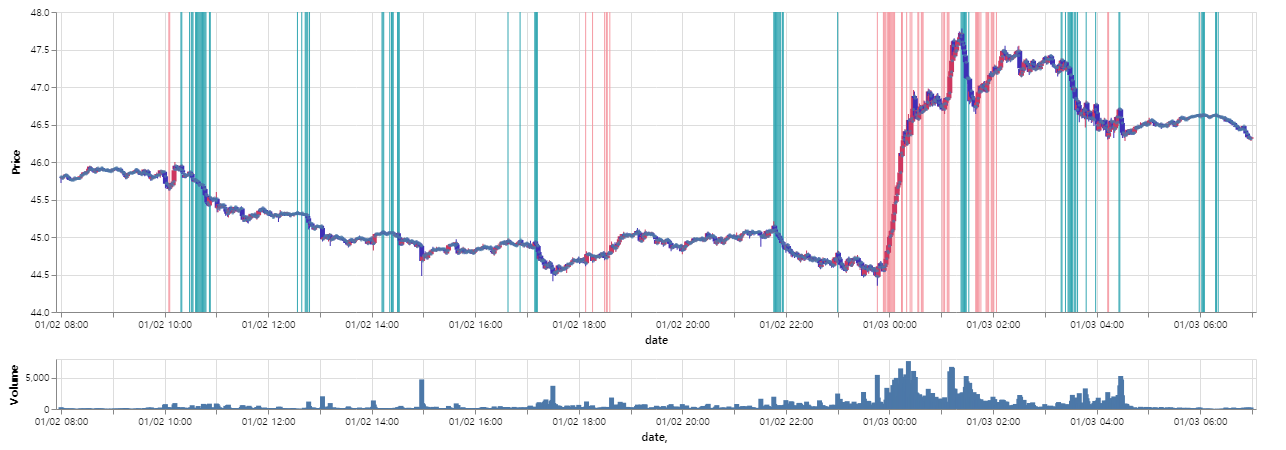

In [120]:
candle_chart(df, reds=reds, blues=blues)

In [129]:
df.set_index('date').resample('5T').max().head(10)

,dt,open,high,low,close,volume,day,max_index,max,min_index,min,last,call,pull,call_max_index,call_max,pull_max_index,pull_max
date,,,,,,,,,,,,,,,,,,
2019-01-02 08:00:00,20190102080400,45.81,45.83,45.80,45.81,261,20190102,33.0,45.94,10.0,45.76,45.92,0.15,0.05,10.0,0.18,59.0,0.21
2019-01-02 08:05:00,20190102080900,45.83,45.84,45.82,45.83,63,20190102,28.0,45.94,5.0,45.76,45.92,0.17,0.07,5.0,0.18,59.0,0.26
2019-01-02 08:10:00,20190102081400,45.77,45.78,45.76,45.77,61,20190102,23.0,45.94,1.0,45.76,45.88,0.18,0.01,1.0,0.18,58.0,0.26
2019-01-02 08:15:00,20190102081900,45.79,45.79,45.78,45.79,72,20190102,18.0,45.94,1.0,45.78,45.85,0.16,0.01,1.0,0.16,53.0,0.26
2019-01-02 08:20:00,20190102082400,45.82,45.84,45.82,45.82,85,20190102,13.0,45.94,53.0,45.80,45.86,0.16,0.02,53.0,0.16,48.0,0.26
2019-01-02 08:25:00,20190102082900,45.86,45.87,45.84,45.86,73,20190102,8.0,45.94,50.0,45.80,45.90,0.11,0.06,50.0,0.15,43.0,0.26
2019-01-02 08:30:00,20190102083400,45.93,45.95,45.90,45.94,123,20190102,8.0,45.94,45.0,45.80,45.87,0.07,0.14,45.0,0.15,38.0,0.26
2019-01-02 08:35:00,20190102083900,45.90,45.91,45.90,45.90,37,20190102,7.0,45.92,40.0,45.80,45.90,0.06,0.10,40.0,0.15,33.0,0.26
2019-01-02 08:40:00,20190102084400,45.92,45.93,45.90,45.92,72,20190102,4.0,45.92,35.0,45.80,45.88,0.04,0.12,35.0,0.15,28.0,0.26


In [128]:
df.head(10)

,dt,open,high,low,close,volume,day,date,max_index,max,min_index,min,last,call,pull,call_max_index,call_max,pull_max_index,pull_max
index,,,,,,,,,,,,,,,,,,,
20190102080000,20190102080000,45.80,45.80,45.72,45.80,261,20190102,2019-01-02 08:00:00,33.0,45.94,10.0,45.76,45.89,0.14,0.04,10.0,0.18,33.0,0.14
20190102080100,20190102080100,45.80,45.80,45.78,45.79,183,20190102,2019-01-02 08:01:00,32.0,45.94,9.0,45.76,45.90,0.15,0.03,9.0,0.18,32.0,0.14
20190102080200,20190102080200,45.78,45.80,45.77,45.80,125,20190102,2019-01-02 08:02:00,31.0,45.94,8.0,45.76,45.91,0.14,0.04,8.0,0.18,31.0,0.14
20190102080300,20190102080300,45.80,45.83,45.80,45.81,68,20190102,2019-01-02 08:03:00,30.0,45.94,7.0,45.76,45.91,0.13,0.05,7.0,0.18,59.0,0.20
20190102080400,20190102080400,45.81,45.82,45.80,45.81,40,20190102,2019-01-02 08:04:00,29.0,45.94,6.0,45.76,45.92,0.13,0.05,6.0,0.18,59.0,0.21
20190102080500,20190102080500,45.82,45.84,45.82,45.83,29,20190102,2019-01-02 08:05:00,28.0,45.94,5.0,45.76,45.92,0.11,0.07,5.0,0.18,58.0,0.21
20190102080600,20190102080600,45.83,45.83,45.81,45.82,35,20190102,2019-01-02 08:06:00,27.0,45.94,4.0,45.76,45.89,0.12,0.06,4.0,0.18,59.0,0.22
20190102080700,20190102080700,45.82,45.83,45.79,45.82,63,20190102,2019-01-02 08:07:00,26.0,45.94,3.0,45.76,45.89,0.12,0.06,3.0,0.18,59.0,0.25
20190102080800,20190102080800,45.81,45.81,45.76,45.80,61,20190102,2019-01-02 08:08:00,25.0,45.94,2.0,45.76,45.88,0.14,0.04,2.0,0.18,58.0,0.25


In [43]:
from decimal import *

CALL = 0
PULL = 1

def calculate_earnings(df, enter_price_type='close', exit_price_type='close', loss_limit=0.1, keep_period=60):
    loss_limit *= -1.0
    result = []
    for i in range(len(df)):
        enter_price = df.iloc[i][enter_price_type]
        
        top_price = Decimal('-Infinity')
        bottom_price = Decimal('Infinity')
        top_price_index = i
        bottom_price_index = i
        
        earning = [Decimal(0), Decimal(0)]
        earning_index = [i, i]
        loss = [Decimal(0), Decimal(0)]
        loss_index = [i, i]
        
        for k in range(i+1, min(i+2+keep_period, len(df))):
            current_high = df.iloc[k]['high']
            current_low = df.iloc[k]['low']
            if (top_price < current_high):
                top_price_index = k
                top_price = current_high
            if (bottom_price > current_low):
                bottom_price_index = k
                bottom_price = current_low
            exit_price = df.iloc[k][exit_price_type]
            current_liquidation = [exit_price - enter_price, enter_price - exit_price]
            for c in range(len(current_liquidation)):
                if (earning[c] < current_liquidation[c]):
                    earning_index[c] = k
                    earning[c] = current_liquidation[c]
                if (loss[c] < loss_limit and loss[c] > current_loss[c]):
                    loss_index[c] = k
                    loss[c] = current_loss[c]

        row = {'dt': df.iloc[i]['dt'], 'open': df.iloc[i]['open'], 'high': df.iloc[i]['high'], 'low': df.iloc[i]['low'], 'close': df.iloc[i]['close']}
        row['enter_price'] = enter_price
        for c in range(len(earning)):
            row['earning{}'.format(c)] = earning[c]
            row['earning_ticks{}'.format(c)] = earning_index[c] - i
            row['loss{}'.format(c)] = loss[c]
            row['loss_ticks{}'.format(c)] = loss_index[c] - i
        result.append(row)
    return pd.DataFrame(result)

In [ ]:
def call_points(df, ):
    

In [4]:
con = sqlite3.connect("CL000_1M.db")

In [82]:
df = pd.read_sql("SELECT * FROM candles where day = '20190102' order by dt", con)

In [83]:
df['date'] = pd.to_datetime(df.dt)
df['index'] = df.dt
df = df.set_index('index')

In [22]:
df.head()

,dt,open,high,low,close,volume,day
index,,,,,,,
20190102080000,20190102080000,45.80,45.80,45.72,45.80,261,20190102
20190102080100,20190102080100,45.80,45.80,45.78,45.79,183,20190102
20190102080200,20190102080200,45.78,45.80,45.77,45.80,125,20190102
20190102080300,20190102080300,45.80,45.83,45.80,45.81,68,20190102
20190102080400,20190102080400,45.81,45.82,45.80,45.81,40,20190102


In [44]:
df0 = calculate_earnings(df, loss_limit=0.05, keep_period=60)

In [45]:
df0.head()

,close,dt,earning0,earning1,earning_ticks0,earning_ticks1,enter_price,high,loss0,loss1,loss_ticks0,loss_ticks1,low,open
0,46.23,20190103080000,0.03,0.46,1,60,46.23,46.29,0,0,0,0,46.13,46.26
1,46.26,20190103080100,0,0.49,0,59,46.26,46.35,0,0,0,0,46.20,46.24
2,46.13,20190103080200,0.01,0.36,1,58,46.13,46.27,0,0,0,0,46.09,46.26
3,46.14,20190103080300,0,0.37,0,57,46.14,46.16,0,0,0,0,46.12,46.13
4,46.12,20190103080400,0,0.35,0,56,46.12,46.14,0,0,0,0,46.12,46.13


In [46]:
df0[(df0.earning_ticks0 < df0.loss_ticks0) & (df0.earning0 >= 0.3)]

,close,dt,earning0,earning1,earning_ticks0,earning_ticks1,enter_price,high,loss0,loss1,loss_ticks0,loss_ticks1,low,open


In [17]:
df0[(df0.pull_earning_ticks < df0.pull_loss_ticks) & (df0.pull_earning >= 0.3)]

,call_earning,call_earning_ticks,call_loss,call_loss_ticks,close,dt,enter_price,high,low,open,pull_earning,pull_earning_ticks,pull_loss,pull_loss_ticks
88,0.02,61,0.07,13,45.91,20190103092800,45.91,45.96,45.89,45.95,0.44,33,0.02,61
89,0.04,60,0.06,13,45.89,20190103092900,45.89,45.94,45.85,45.91,0.42,32,0.04,60
90,0.02,59,0.07,11,45.91,20190103093000,45.91,45.91,45.88,45.90,0.44,31,0.02,59
91,0.05,58,0.05,11,45.88,20190103093100,45.88,45.91,45.87,45.91,0.41,30,0.05,58
92,0.03,57,0.06,9,45.90,20190103093200,45.90,45.90,45.87,45.88,0.43,29,0.03,57
93,0.05,56,0.05,9,45.88,20190103093300,45.88,45.90,45.88,45.89,0.41,28,0.05,56
94,0.04,55,0.06,8,45.89,20190103093400,45.89,45.90,45.88,45.89,0.42,27,0.04,55
95,0.05,54,0.05,7,45.88,20190103093500,45.88,45.90,45.84,45.89,0.41,26,0.05,54
96,0.06,53,0.06,7,45.87,20190103093600,45.87,45.89,45.86,45.88,0.4,25,0.06,53
97,0.03,52,0.06,4,45.90,20190103093700,45.90,45.90,45.86,45.87,0.43,24,0.03,52


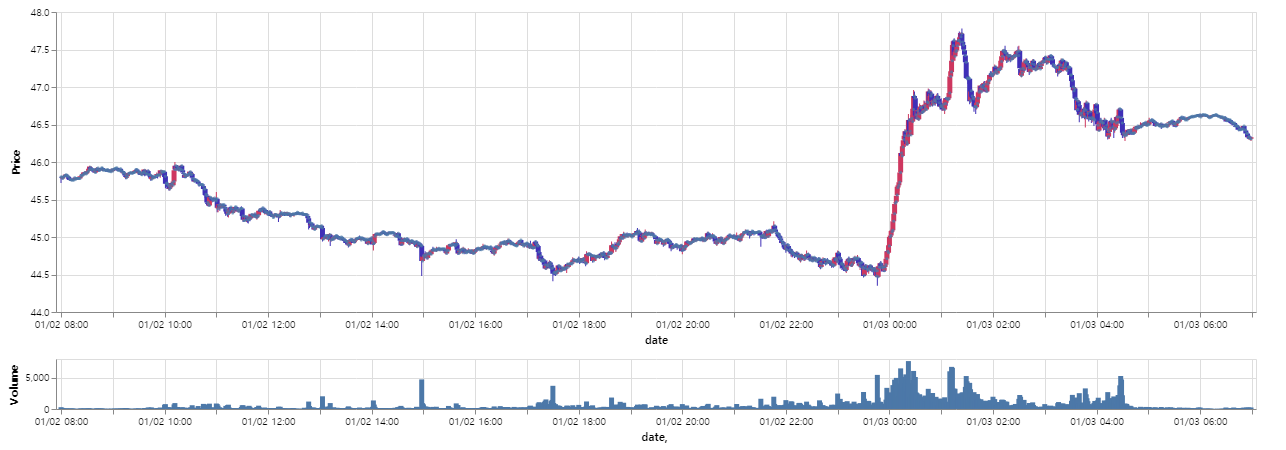

In [77]:
candle_chart(df)

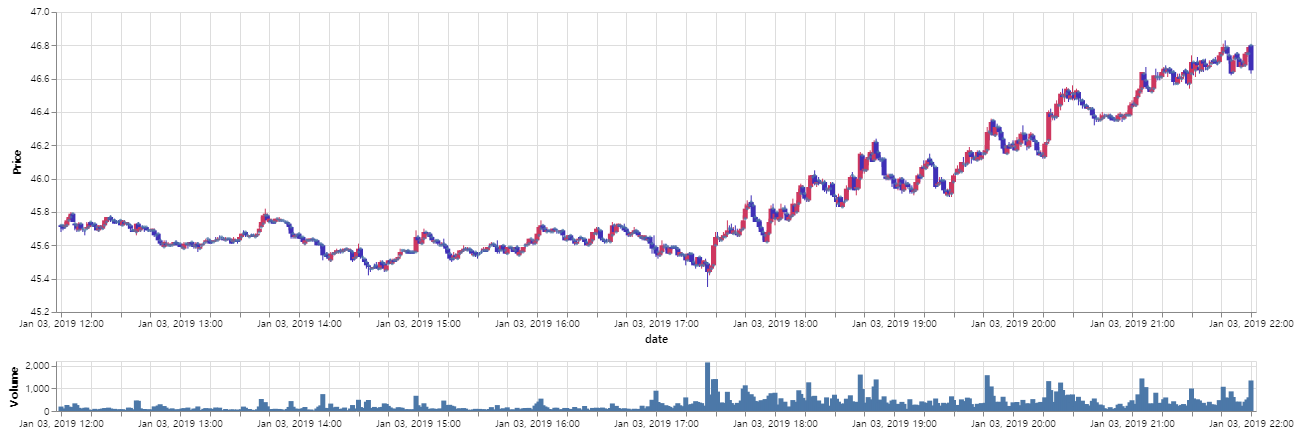

In [204]:
candle_chart(df, index_range=['20190103120000','20190103220000'])

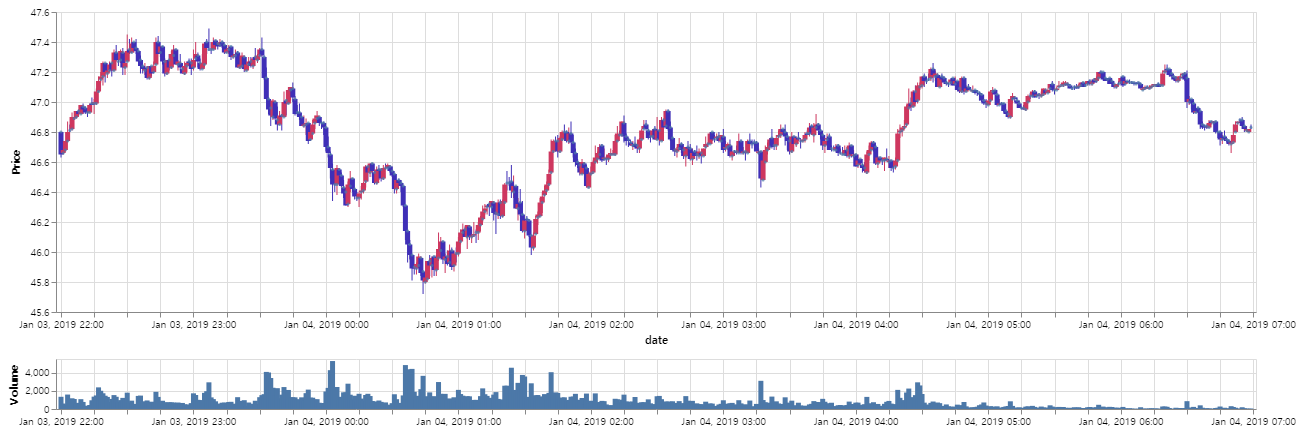

In [215]:
candle_chart(df, index_range=['20190103220000',None])

In [217]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.sql import func

from entity import Candle, Base

In [218]:
engine=create_engine('sqlite:///CL018_1M.db')
session = sessionmaker(bind=engine)()
Base.metadata.create_all(engine)

In [219]:
session.query(func.max(Candle.dt)).one()[0]

In [220]:
#F06J000  20160603131800